# Custom networks

Observational data is often extremely complex and high dimensional. `swyft` is designed to share the processing of observational data before passing it to each marginal classifier for marginal likelihood-to-evidence ratio estimation. This can be a combination of learnable transformations along with static ones. This notebook demonstrates that techinque. We denote this part of the network the _head_.

In this example, we aim to estimate the $x$ and $y$ coordinates and radius $r$ of a ring within an image.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [3]:
import numpy as np
import pylab as plt
import torch

import swyft

In [4]:
# Set randomness
np.random.seed(25)
torch.manual_seed(25)

# swyft
device = 'cuda' if swyft.utils.is_cuda_available() else "cpu"
n_parameters = 3
observation_key = "x"
n_training_samples = 10_0000
marginal_indices_1d, marginal_indices_2d = swyft.utils.get_corner_marginal_indices(n_parameters)

## Simulator and observation

Generate the "true observation," prepare the simulator.

Seperate the simulator from additive noise where possible (this comes in the next section). This allows for data augmentation during training.

In [5]:
def simulator(v, w = 0.03):
    "Ring simulator"
    x1, y1, r = v
    
    grid = np.linspace(0, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    mu = np.exp(-(R1-r)**2/w**2/2)
    
    # Add random distortions in terms of lines
    for _ in range(20):
        xr = np.random.rand(2)
        mu += 0.8*np.exp(-(X*xr[0]+Y*(1-xr[0])-xr[1])**2/0.01**2)
        
    return {observation_key: np.expand_dims(np.array(mu), 0)}


v_o = np.array([0.5, 0.5, 0.3])
observation_o = simulator(v_o)

n_observation_features = observation_o[observation_key].shape[0]
observation_shapes = {key: value.shape for key, value in observation_o.items()}

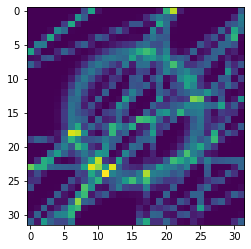

In [6]:
plt.imshow(observation_o[observation_key][0])

In [7]:
simulator = swyft.Simulator(
    simulator,
    ["x1", "y1", "r"],
    sim_shapes=observation_shapes
)

## prior, storage, additive noise model, and dataset

We include the noise model with the dataset so that every draw from the dataset has different noise. It is a form of data augmentation.

In [8]:
def noise(obs, v, sigma=0.1):
    mu = obs[observation_key]
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return {observation_key: x}

In [9]:
low = np.zeros(n_parameters)
high = np.array([1., 1., 0.5])
prior = swyft.get_uniform_prior(low, high)

store = swyft.Store.memory_store(simulator)
# drawing samples from the store is Poisson distributed. Simulating slightly more than we need avoids attempting to draw more than we have.
store.add(n_training_samples + 0.01 * n_training_samples, prior)
store.simulate()

Creating new store.
Store: Adding 100441 new samples to simulator store.


In [10]:
dataset = swyft.Dataset(
    n_training_samples, 
    prior, 
    store, 
    simhook=noise
)

## Define the network architechture

We will create a function to instantiate networks appropriate for our data. This function is very similar to the convenience function `swyft.networks.classifier.get_marginal_classifier`. 

The most natural way to design neural networks for `swyft` is to create functions which process hyperparameters and output instantiated `torch.nn.Modules`. We recommend using the `swyft.networks.classifier.Network` class to simplify the network design process. The necessary data processing required for `swyft` is automatically done in `Network`.

In [11]:
class CustomObservationTransform(torch.nn.Module):
    def __init__(self, observation_key: str, observation_shapes: dict):
        super().__init__()
        self.observation_key = observation_key
        self.n_features = 160  # This attribute must be defined!
        
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(observation_shapes)
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
        )

    def forward(self, obs: dict) -> torch.Tensor:
        x = self.online_z_score(obs)
        x = x[self.observation_key]
        return self.net(x)


def get_custom_marginal_classifier(
    observation_transform,
    marginal_indices: tuple,
    n_parameters: int,
    hidden_features: int,
    num_blocks: int,
    marginal_classifier = None,
    parameter_online_z_score: bool = True,
) -> torch.nn.Module:
    n_observation_features = observation_transform.n_features

    parameter_transform = swyft.networks.ParameterTransform(
        n_parameters, marginal_indices, online_z_score=parameter_online_z_score
    )
    n_marginals, n_block_parameters = parameter_transform.marginal_block_shape

    if marginal_classifier is None:
        marginal_classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=hidden_features,
            num_blocks=num_blocks,
        )
    else:
        marginal_classifier = marginal_classifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=hidden_features,
            num_blocks=num_blocks,
        )

    return swyft.networks.Network(
        observation_transform,
        parameter_transform,
        marginal_classifier,
    )

## Train a 1d marginal estimator

In [12]:
network_1d = get_custom_marginal_classifier(
    observation_transform=CustomObservationTransform(observation_key, observation_shapes),
    marginal_indices=marginal_indices_1d,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)

mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)

In [13]:
mre_1d.train(dataset, max_epochs=2)

training: lr=0.0005, epoch=2, validation loss=1.753


## Create a simple violin plot to view the 1d marginals

In [14]:
n_rejection_samples = 5_000

posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
samples_1d = posterior_1d.sample(n_rejection_samples, observation_o)

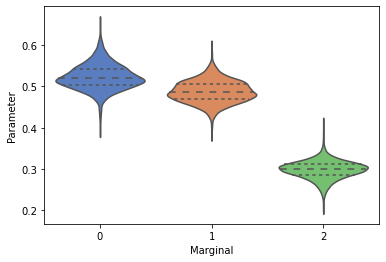

In [15]:
_ = swyft.violin(samples_1d)

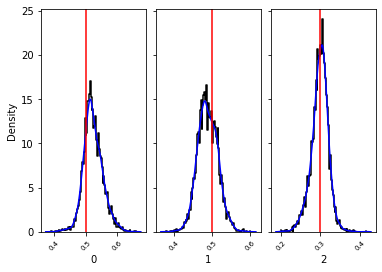

In [16]:
_, _ = swyft.hist1d(samples_1d, truth=v_o, kde=True)

## What about the "tail?"

We discussed how data processing can be complex for simulated data and thus created the `CustomObservationTransform`. The input side of `swyft` was called the 'head', but what about the output side? i.e., the tail?

`swyft` estimates a log likelihood-to-evidence ratio for all the marginals for the given parameters of interest. We implement this in parallel by batching the outputs together as another dimension of our output. PyTorch's limitation of working with rectangular arrays is why one must seperately estimate one-dimensional marginals from two-dimensional marginals with `swyft` using two `MarginalRatioEstimators`, one for all one-dimensional marginals another for all two-dimensional marginals. This technical issue could be overcome with PyTorch geometric or looping over estimated marginals, but there may be issues w.r.t. the weighing of marginals of different dimension. We find the current method satisfactory.

The next section exemplifies how to create a custom marginal classifier, aka a "tail" network. This is the part of the classifier that uses the featurized observational data with marginal parameters concatenated and estimates a log likelihood-to-evidence ratio. The main difference from a normal neural network is the addition of another batch dimension. The name classifier is a bit of a misnomer because it estimates the log likelihood-to-evidence ratio, but one can think of the output as $\sigma^{-1}(\rho(x, \theta))$ where $\rho$ is a classifier and $\sigma^{-1}$ is the inverse sigmoid / logit function.

In [17]:
from swyft.networks.channelized import LinearWithChannel, BatchNorm1dWithChannel

In [18]:
class CustomMarginalClassifier(torch.nn.Module):
    def __init__(
        self,
        n_marginals: int,
        n_combined_features: int,
        hidden_features: int,
        num_blocks=2,
    ) -> None:
        super().__init__()
        self.n_marginals = n_marginals
        self.n_combined_features = n_combined_features
        
        blocks = [
            LinearWithChannel(self.n_marginals, self.n_combined_features, hidden_features),
            torch.nn.ReLU(),
            BatchNorm1dWithChannel(self.n_marginals, hidden_features),
        ]
        for _ in range(num_blocks - 1):
            blocks.append(LinearWithChannel(self.n_marginals, hidden_features, hidden_features))
            blocks.append(torch.nn.ReLU())
            blocks.append(BatchNorm1dWithChannel(self.n_marginals, hidden_features))
        
        self.net = torch.nn.Sequential(
            *blocks,
            LinearWithChannel(self.n_marginals, hidden_features, 1)
        )

    def forward(
        self, features: torch.Tensor, marginal_block: torch.Tensor
    ) -> torch.Tensor:
        fb = features.unsqueeze(1).expand(-1, self.n_marginals, -1)  # B, M, O
        combined = torch.cat([fb, marginal_block], dim=2)  # B, M, O + P
        return self.net(combined).squeeze(-1)  # B, M

In [19]:
network_1d = get_custom_marginal_classifier(
    observation_transform=CustomObservationTransform(observation_key, observation_shapes),
    marginal_indices=marginal_indices_1d,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
    marginal_classifier=CustomMarginalClassifier,  # This is passed as a function because the arguments are computed inside get_custom_marginal_classifier
)

mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)

In [20]:
mre_1d.train(dataset, max_epochs=2)

training: lr=0.0005, epoch=2, validation loss=1.928


In [21]:
n_rejection_samples = 5_000

posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
samples_1d = posterior_1d.sample(n_rejection_samples, observation_o)

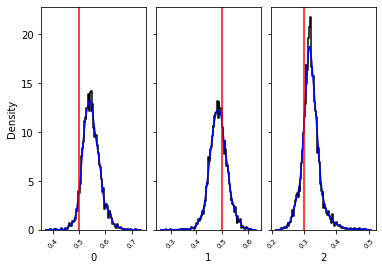

In [22]:
_, _ = swyft.hist1d(samples_1d, truth=v_o, kde=True)